# Weighted average predictions

A prediction with expert advice is done considering
1. A decision space $\cal D$,
2. an outcome space $\cal y$,
3. A loss function $\ell$, and
4. a set of $\cal E$ of experts indices

For each round $t=1,2,\ldots$
1. The environment chooses the next outcome $y_t$ and the expert advice $\{f_{e,t} \in {\cal D}: e \in {\cal E}\}$;
2. The forecaster chooses the prediction $\hat{p}_t \in {\cal D}$;
3. The environmente reveals the next outcome $y_t \in {\cal Y}$;
4. the forecaster incurs loss $\ell(\hat p_t, y_t)$ and each expert $e$ incurs loss $\ell(f_{e,t}, y_t)$j

In [26]:
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial

In [192]:
%config InlineBackend.figure_format = "retina"

### Regret
The forecaster's goal is to keep as small as possible cumulative regret. For expert $e$, this quantity is defined by

$$
    R_{e,T} = \sum_{t=1}^T\left(\ell(\hat p_t, y_t)  - \ell(f_{e, t}, y_t)\right) = \hat L_T - L_{e, T}.
$$


### The weighted average forecaster
(A forecaster based on the potential $\Phi$)  
Using the notion of potential function, we give the following definition of the weighted average forecaster

$$
    \hat p_t = \frac{\sum_{e=1}^E \nabla\Phi(R_t)_e f_{e,t}}{\sum_{e=1}^E \nabla\Phi(R_t)_e}
$$

In [67]:
def loss(yhat, y):
    return (yhat - y) ** 2

def potential(x, p):
    xhat = jnp.maximum(0, x)
    return jnp.linalg.norm(xhat, p) ** 2

gradp = jax.grad(potential)
vloss = jax.vmap(loss, in_axes=(0, None))

## Evaluating the forecaster

In [198]:
key = jax.random.PRNGKey(314)

key_oracle, key_experts, key_noise = jax.random.split(key, 3)

n_experts = 10
n_timesteps = 5_000
true_expert_where = 10

beta = 0.9
oracle = jax.random.bernoulli(key_oracle, p=0.5, shape=(n_timesteps,))
experts = jax.random.bernoulli(key_experts, p=0.5, shape=(n_timesteps, n_experts-1))


p_mistake = 0.1
mistakes = jax.random.bernoulli(key_noise, p=p_mistake, shape=(n_timesteps,))
true_expert  = oracle ^ mistakes # Flip bit if mistake

p_mistake = 0.2
mistakes = jax.random.bernoulli(key_noise, p=p_mistake, shape=(n_timesteps,))
true_expert2  = oracle ^ mistakes # Flip bit if mistake


# Insert the one true expert to the list of experts
experts = jnp.insert(experts, true_expert_where, true_expert, axis=1)
experts = jnp.insert(experts, true_expert_where, true_expert2, axis=1)
_, n_experts = experts.shape

oracle = oracle.astype(float)
min_errors = (true_expert != oracle).cumsum()

## Experts

In [265]:
key = jax.random.PRNGKey(314)

key_oracle, key_experts, key_noise, key_errs = jax.random.split(key, 4)

n_experts = 20
n_timesteps = 5_000
true_expert_where = 10

oracle = jax.random.bernoulli(key_oracle, p=0.5, shape=(n_timesteps,))


p_mistake = 0.1
@partial(jax.vmap, in_axes=(0, 0, None), out_axes=-1)
def create_mistakes(key, p, T):
    mistakes = jax.random.bernoulli(key, p=p, shape=(T,))
    return mistakes

keys_noise = jax.random.split(key_noise, n_experts)
ps_mistakes = jax.random.beta(key_errs, a=2, b=7, shape=(n_experts,))
mistakes = create_mistakes(keys_noise, ps_mistakes, n_timesteps)
experts = (mistakes ^ oracle[:, None]).astype(float)

In [266]:
ps_mistakes

Array([0.2812411 , 0.10967062, 0.21538654, 0.17952584, 0.40576443,
       0.01985334, 0.11199575, 0.20912248, 0.16101764, 0.09730785,
       0.35588214, 0.58493114, 0.02365859, 0.26613575, 0.19203997,
       0.16361535, 0.39438263, 0.21035549, 0.40669772, 0.32594386],      dtype=float32)

In [267]:
def forecast_step(experts_curr, regret_prev):
    weights = gradp(regret_prev, pnorm)
    forecast = weights @ experts_curr / weights.sum()
    return forecast

def update_regret(forecast, experts, oracle, regret_prev):
    inst_regret = loss(forecast, oracle) - loss(experts, oracle)
    regret = regret_prev + inst_regret
    return regret

def step(regret, xs):
    experts, oracle = xs
    forecast = forecast_step(experts, regret)
    regret_new = update_regret(forecast, experts, oracle, regret)
    return regret_new, (forecast, regret_new)

In [268]:
regret = jnp.ones(n_experts)
xs = (experts, oracle)
_, (forecast, regret_hist) = jax.lax.scan(step, regret, xs)

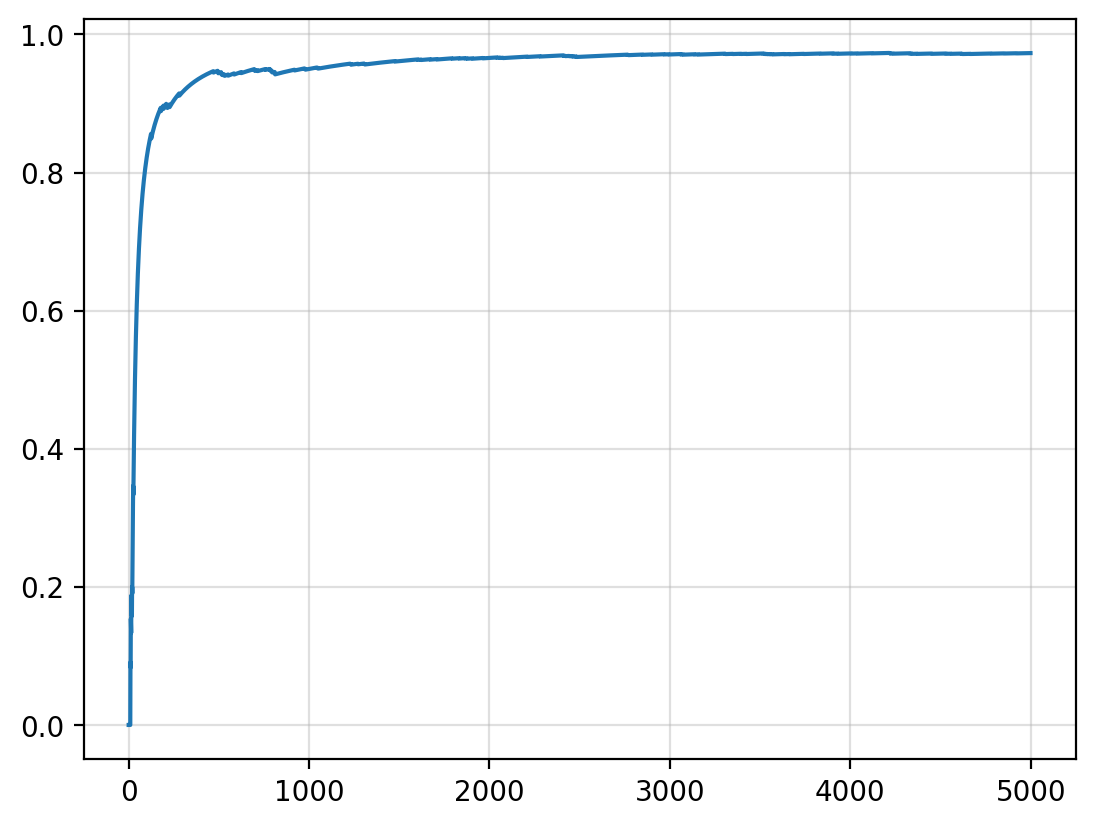

In [269]:
rolling_acc = (forecast == oracle).cumsum() / jnp.arange(1, n_timesteps + 1)
plt.plot(rolling_acc)
plt.grid(alpha=0.4)

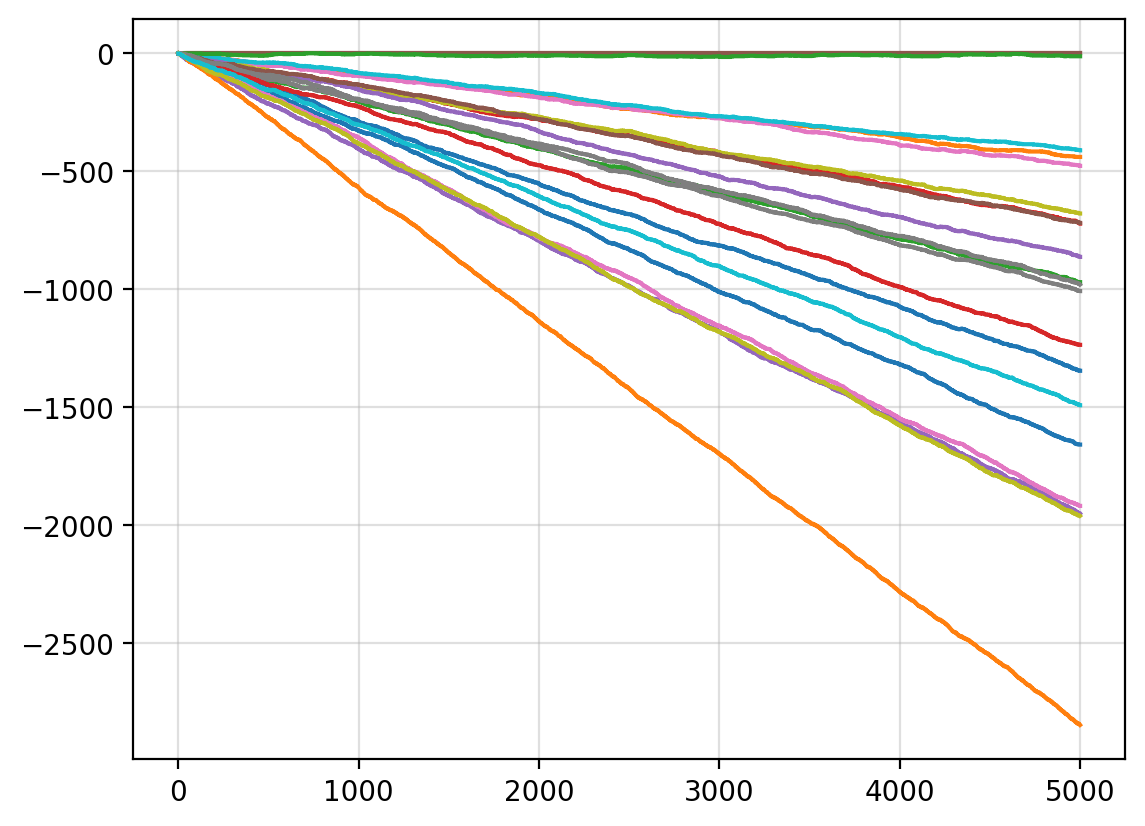

In [270]:
plt.plot(regret_hist)
plt.grid(alpha=0.4);